# Basic Recommendation System Using Neural Network

This is a basic recommendation system designed as a classification problem. This uses only the user IDs, book ISBNs, and the ratings to predict which books are rated by a certain user. The dataset used here is [Book Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The recommendation system is built for top 50 users. Each user ID and ISBN is embedded and concatenated before being passed into a Fully Connected Neural Network. The loss function used is the Cross-entropy Loss and the evaluation metric used is the Hit rate. 

The train set and the test set contain data of top 50 users. The train set consists of 199 books that are rated and 400 books that are not rated by an user. The test set contains only one book rated by the user and this book is absent in the train set. There are 600 books in the test set that are not rated by the user. The rated books are labeled as 1 and the not-rated books are labeled as 0 in the train and the test sets. Top 10 books are extracted according to the prediction probability score and listed as the recommended items for the user. This list may contain lesser books, if the model predicts less than 10 books to be rated by the user. 

The hit rate is 0.58, which means that 29 (out of 50) users' recommendation list contains the book rated in actual by the user. This very basic system is built on a small set of data due to heavy computational load. It is observed that with a more imbalanced training set containing far more not-rated items than the rated items the model training is more difficult and results in a lower hit rate for longer recommendation list.

In [1]:
import numpy as np
import pandas
import torch
import warnings
import matplotlib.pyplot as plt

In [2]:
books_path = '/Users/naziafarhat/Desktop/Notebooks_old/Data/BX-CSV-Dump/BX-Books.csv'
users_path = '/Users/naziafarhat/Desktop/Notebooks_old/Data/BX-CSV-Dump/BX-Users.csv'

In [3]:
# Function to remove quotes from column names

rm_quotes = lambda x: x.replace('"', '')

In [4]:
# Books dataframe

books = pandas.read_csv(books_path, sep = '\";\"', engine = 'python', encoding='ISO-8859–1').replace('"', '', regex = True)
books = books.rename(columns = rm_quotes)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
# Users dataframe

users = pandas.read_csv(users_path, sep = '\";\"', engine = 'python', encoding='ISO-8859–1').replace('"', '', regex = True)
users = users.rename(columns = rm_quotes)
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa;NULL",None
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia;NULL",None
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom;NULL",None


In [6]:
# Ratings dataframe

ratings = pandas.read_csv('/Users/naziafarhat/Desktop/Notebooks_old/Data/BX-CSV-Dump/BX-Book-Ratings.csv', sep = '\";\"', engine = 'python', encoding='ISO-8859–1').replace('"', '', regex = True)
ratings = ratings.rename(columns = rm_quotes)
ratings['Book-Rating'] = ratings['Book-Rating'].astype(int)+1
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,1
1,276726,0155061224,6
2,276727,0446520802,1
3,276729,052165615X,4
4,276729,0521795028,7


In [7]:
ratings['User-ID'].unique().shape

(105283,)

In [8]:
warnings.filterwarnings("ignore")

train_set = []
test_set = []

users_to_idx = {u: i for i, u in enumerate(ratings['User-ID'].unique())}
books_to_idx = {b: i for i, b in enumerate(ratings['ISBN'].unique())}

idx_to_users = {v: k for k, v in users_to_idx.items()}
idx_to_books = {v: k for k, v in books_to_idx.items()}

top_uids = ratings['User-ID'].value_counts().head(50).keys()

# Get top users only
for uid in top_uids:
    uid_rows_rated = ratings[ratings['User-ID'] == uid].dropna()
    uid_rows_rated['Book-Rating'].values[:] = 1
    
    not_uid_rows_rated = ratings[ratings['User-ID'] != uid]
    not_uid_rows_rated['Book-Rating'].values[:] = 0
    not_uid_rows_rated['User-ID'].values[:] = uid
    
    uid_rows_rated['ISBN'] = uid_rows_rated['ISBN'].map(books_to_idx).to_frame()
    uid_rows_rated['User-ID'] = uid_rows_rated['User-ID'].map(users_to_idx).to_frame()
    
    not_uid_rows_rated['User-ID'] = not_uid_rows_rated['User-ID'].map(users_to_idx).to_frame()
    not_uid_rows_rated['ISBN'] = not_uid_rows_rated['ISBN'].map(books_to_idx).to_frame()
    
    rated = uid_rows_rated.to_numpy()
    not_rated = not_uid_rows_rated.to_numpy()
    
    train_set.extend(np.vstack((rated[1:200], not_rated[:400])))
    test_set.extend(np.vstack((rated[0], not_rated[400:1000])))

train_set = np.stack(train_set)
test_set = np.stack(test_set)

train_set.shape, test_set.shape

((29950, 3), (30050, 3))

In [9]:
import torch
import copy

class RecNet:
    
    def __init__(self, 
                 n_users, 
                 n_books, 
                 n_embed, 
                 n_classes, 
                 embed_dropout = 0.2, 
                 layers = [10, 20, 10], 
                 net_dropout = 0.2):

        self.Xmeans = None
        self.Xstds = None
        self.error_trace = []
        self.nnet = self.construct_network(n_users, 
                                           n_books, 
                                           n_embed, 
                                           n_classes, 
                                           embed_dropout, 
                                           layers, 
                                           net_dropout)
        
    def construct_network(self, 
                          n_users, 
                          n_books, 
                          n_embed, 
                          n_classes, 
                          embed_dropout, 
                          layers, 
                          dropout):
        
        hidden_list = [torch.nn.Embedding(n_users, n_embed), 
                       torch.nn.Embedding(n_books, n_embed), 
                       torch.nn.Dropout(embed_dropout)]
        in_units = n_embed*2
        for out_units in layers:
            hidden_list.extend([torch.nn.Linear(in_units, out_units), 
                                torch.nn.ReLU(), 
                                torch.nn.Dropout(dropout)])
            in_units = out_units
        hidden_list.append(torch.nn.Linear(in_units, n_classes))
        return torch.nn.Sequential(*hidden_list)
    
    def _setup_standardize(self, X):
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
        if self.Xstds is None:
            self.Xstds = X.std(0)
        self.Xconstant = self.Xstds == 0
        self.XstdsFixed = copy.copy(self.Xstds)
        self.XstdsFixed[self.Xconstant] = 1
        
    def _standardizeX(self, X):
        X_standardized = (X - self.Xmeans) / self.XstdsFixed
        X_standardized[:, self.Xconstant] = 0.0
        return X_standardized
    
    def _unstandardizeX(self, Xs):
        return Xs * self.XstdsFixed + self.Xmeans
    
    def forward(self, X):
        Y = self.nnet[2](torch.cat((self.nnet[0](X[:, 0]), self.nnet[1](X[:, 1])), dim = 1))
        for m in self.nnet[3:]:
            Y = m(Y)
        return Y
    
    def train(self, X, T, learning_rate = 0.01, n_epochs = 100, optimizer = 'Adam', loss = 'CrossEntropy', batch_size = 50):
        # Convert to torch tensor
        if not torch.is_tensor(X):
            X = torch.tensor(X)
        if not torch.is_tensor(T):
            T = torch.tensor(T.reshape(-1))
        
        # Create tensor dataset for batch training
        trainset = torch.utils.data.TensorDataset(X, T)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)
        
        # Define optimizer and loss function
        optimizer = torch.optim.Adam(self.nnet.parameters(), lr = learning_rate)
        loss_F = torch.nn.CrossEntropyLoss()
        
        # Use gpu
        device = torch.device('mps')
        self.nnet = self.nnet.to(device)
        
        # Switch on train mode of the neural net for dynamic computation
        self.nnet.train()
        
        # Train the network
        for epoch in range(n_epochs):
            batch_error = []
            for Xt, Tt in trainloader:
                Xt = Xt.to(device)
                Tt = Tt.to(device)
                Yt = self.forward(Xt.long())
                error = loss_F(Yt, Tt)
                error.backward()
                optimizer.step()
                optimizer.zero_grad()
                batch_error.append(error.item())
            self.error_trace.append(np.array(batch_error).mean())
            
    def use(self, X):
        self.nnet = self.nnet.to('cpu')
        self.nnet.eval()
        Y = self.forward(X)
        
        Ymax = torch.max(Y, axis = 1)[0].reshape(-1, 1)
        Yexp = torch.exp(Y - Ymax)
        denom = torch.sum(Yexp, axis = 1).reshape(-1, 1)
        Y_prob = (Yexp / denom).detach().numpy()
        
        Y_class = np.argmax(Y_prob, axis=1)
        return Y_class, Y_prob
    
    def get_error_trace(self):
        return self.error_trace
        

In [80]:
# Find the indices of the samples that contain the books rated by an user. (pos_actual)
# Find the indices predicted by the reco system. (pos_pred)
# Get the number of correctly predicted indices.


def recommend_and_evaluate(uid, Y_class, Y, X, T, top_k = 10):
    uid_indices = np.where(X[:, 0] == users_to_idx[uid])[0]
    user_book = X[uid_indices]
    actual = T[uid_indices]
    preds = Y_class[uid_indices]
    conf = Y[uid_indices]
    pos_pred = np.where(preds == 1)[0]
    conf_pred = np.max(conf[pos_pred], axis = 1)
    pos_actual = np.where(actual == 1)[0]
    
    # Hit Ratio
    rec_order = np.argsort(conf_pred)[::-1][:top_k] # conf
    rec_books = [idx_to_books[r] for r in user_book[rec_order, 1]]
    
    actual_book = idx_to_books[user_book[pos_actual.item(), 1]]
    
    if pos_actual in rec_order: 
        return (rec_books, conf_pred[rec_order], 1, actual_book)
    else:
        return (rec_books, conf_pred[rec_order], 0, actual_book)        

In [11]:
# Build the model

recnet = RecNet(n_users = len(users_to_idx), 
                n_books = len(books_to_idx), 
                n_embed = 20, #100, 
                n_classes = len(np.unique(train_set[:, 2])), 
                embed_dropout = 0.2, 
                layers = [5], #[3, 5], 
                net_dropout = 0.2)


In [12]:
# Train the model

recnet.train(X = train_set[:, :2], T = train_set[:, 2:], learning_rate = 0.01, n_epochs = 50)

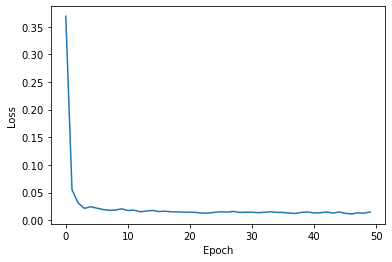

In [13]:
# Plot of Loss vs Epoch during the training process

plt.plot(recnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Evaluation: Hit Rate

In [131]:
# Get the recommendation list for the test set

Y_class, Y = recnet.use(X = torch.tensor(test_set[:, :2]))
count = 0
uid_rec = {}
hit_uid = []
for u in top_uids:
    uid_rec[u] = recommend_and_evaluate(uid = u, 
                                             Y_class = Y_class, 
                                             Y = Y, 
                                             X = test_set[:, :2], 
                                             T = test_set[:, 2:], 
                                             top_k = 10)


for k, v in uid_rec.items():
    count += v[2]
    if v[2] is 1:
        hit_uid.append(k)
        
print(f'Number of hits: {count}')

# Hit rate

print(f'Hit rate: {count/len(top_uids)}')

Number of hits: 29
Hit rate: 0.58


## Recommended books

In [132]:
# Recommended Books found in books DF for a hit user-id

user_serial = hit_uid[0]
rec_isbn = np.array(uid_rec[user_serial][0])
rec_isbn_found = rec_isbn[np.isin(rec_isbn, books['ISBN'])]
rec_conf_found = np.array(uid_rec[user_serial][1])[np.isin(rec_isbn, books['ISBN'])]

In [133]:
# Books being recommended for that hit user-id

recommendation_df = books.iloc[pandas.Index(books['ISBN']).get_indexer(rec_isbn_found)]
recommendation_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
211050,0002241447,The Thief of Always: A Fable,Clive Barker,1992,Harpercollins Publisher,http://images.amazon.com/images/P/0002241447.0...,http://images.amazon.com/images/P/0002241447.0...,http://images.amazon.com/images/P/0002241447.0...
5355,2070419657,Soie,Alessandro Baricco,2001,Gallimard,http://images.amazon.com/images/P/2070419657.0...,http://images.amazon.com/images/P/2070419657.0...,http://images.amazon.com/images/P/2070419657.0...
46620,3822858617,Georgia O'Keeffe 1887-1986: Flowers in the Des...,Britta Benke,2001,Taschen,http://images.amazon.com/images/P/3822858617.0...,http://images.amazon.com/images/P/3822858617.0...,http://images.amazon.com/images/P/3822858617.0...
106773,3808572612,Arbeitsbuch Betriebswirtschaftslehre. Praxisor...,Detlev Nolte,1999,Europa-Lehrmittel,http://images.amazon.com/images/P/3808572612.0...,http://images.amazon.com/images/P/3808572612.0...,http://images.amazon.com/images/P/3808572612.0...
71772,0671025368,The Coldest Winter Ever,Sister Souljah,2000,Pocket,http://images.amazon.com/images/P/0671025368.0...,http://images.amazon.com/images/P/0671025368.0...,http://images.amazon.com/images/P/0671025368.0...


In [134]:
# Name of the recommended books

list(recommendation_df['Book-Title'])

['The Thief of Always: A Fable',
 'Soie',
 "Georgia O'Keeffe 1887-1986: Flowers in the Desert (Basic Art)",
 'Arbeitsbuch Betriebswirtschaftslehre. Praxisorientiert fÃ?Â¤cherÃ?Â¼bergreifend. (Lernmaterialien)',
 'The Coldest Winter Ever']

In [135]:
# Probabilities / Confidence score of the recommended books

conf_score = rec_conf_found
conf_score

array([0.9953556, 0.9953556, 0.9953556, 0.9953556, 0.9953556],
      dtype=float32)

In [136]:
# Actual book rated by that user

actual_book_rated = books[books['ISBN'] == uid_rec[user_serial][3]]['Book-Title'].item()
actual_book_rated

'The Thief of Always: A Fable'

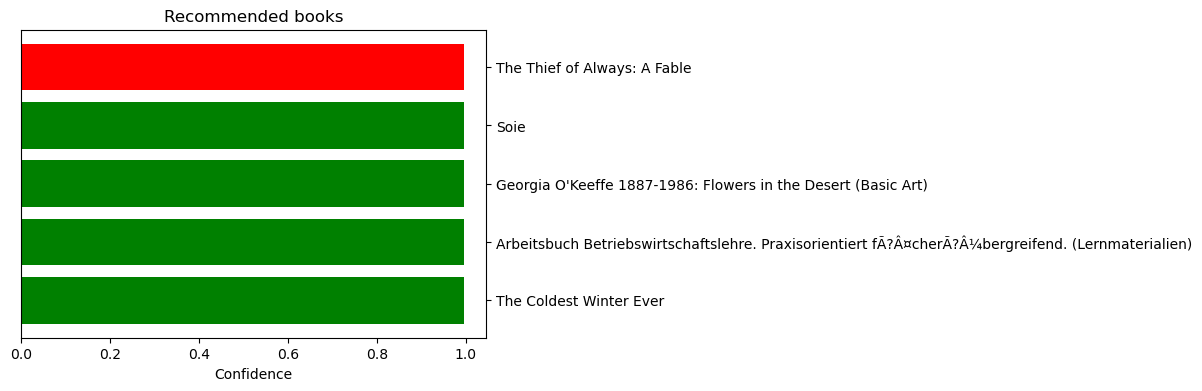

In [137]:
# Plot of the recommended books for that user

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (6, 4))

booksrec = list(recommendation_df['Book-Title']) 
y_pos = np.arange(len(booksrec))
confidence = 1 * conf_score 

#cm = plt.cm.get_cmap('magma') #RdYlBu_r
#X = confidence
#x_span = X.max()-X.min()
#C = [cm(((x-X.min())/x_span)) for x in X]

C = ['r' if b == actual_book_rated else 'g' for b in booksrec]

ax.barh(y_pos, confidence, align='center', color = C)
ax.set_yticks(y_pos, labels=booksrec)
ax.yaxis.tick_right()
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Confidence')
ax.set_title('Recommended books')

plt.show()

## A look at the publication year of the recommended books

In [139]:
# Get recommended books and their publication years for 5 users

n_users_to_plot = 5

user_year_dict = {}

for i in range(n_users_to_plot):
    user_serial_p = hit_uid[i]
    rec_isbn_p = np.array(uid_rec[user_serial_p][0])
    rec_isbn_found_p = rec_isbn_p[np.isin(rec_isbn_p, books['ISBN'])]
    user_year_dict[user_serial_p] = list(books.iloc[pandas.Index(books['ISBN']).get_indexer(rec_isbn_found_p)]['Year-Of-Publication'])

In [140]:
# These are the publication years for each user.

user_year_dict

{'153662': [1992, 2001, 2001, 1999, 2000],
 '98391': [2002, 2004, 2001, 1993, 1994, 2000, 2004],
 '212898': [1989, 1992, 1995, 1990, 1990, 1993, 1990, 1990, 1989],
 '76352': [1996, 2001, 1999, 2002, 2002, 1998, 2003, 2000],
 '234623': [1982, 2000, 1990, 1998, 2004]}

In [186]:
# Prepare the data for scatter plot.

year_list = []
user_list = []
color_list = []
area_list = []
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(user_year_dict))))

for k, v in user_year_dict.items():
    user_list.extend([k]*len(v))
    year_list.extend(v)
    area_list.extend(list((10 + np.random.rand(len(v))*20)**2))
    c = next(colors)
    color_list.extend([c for _ in range(len(v))])

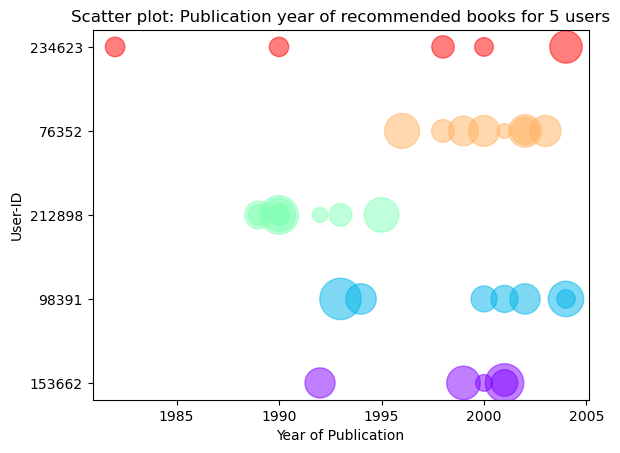

In [187]:
# Plot shows the publication years of the recommeded books for each user in a different color.

plt.scatter(year_list, user_list, s = area_list, c=color_list, alpha=0.5)
plt.xlabel('Year of Publication')
plt.ylabel('User-ID')
plt.title(f'Scatter plot: Publication year of recommended books for {len(user_year_dict)} users');

From the scatter plot it seems that the model is recommending the books published in the same decade for a user. There are exceptions of course. To get a better understaing of what features the model is considering when predicting the recommendation list it is required to analyze the dataset in more detail and compare with the prediction results.

## References and Acknowledgements

https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b

https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

https://neptune.ai/blog/recommender-systems-metrics

https://towardsdatascience.com/modern-recommendation-systems-with-neural-networks-3cc06a6ded2c

https://towardsdatascience.com/ranking-evaluation-metrics-for-recommender-systems-263d0a66ef54

https://analyticsindiamag.com/how-to-measure-the-success-of-a-recommendation-system/

https://www.kaggle.com/code/nandeshwar/mean-average-precision-map-k-metric-explained-code/notebook

https://stackoverflow.com/questions/56658723/how-to-maintain-order-when-selecting-rows-in-pandas-dataframe

https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap

https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib